# Fake News Detection

**Goal:** Predict whether a given news article is real or fake.

**Tech:** NLP preprocessing, TF-IDF vectorization, Logistic Regression, Model Evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
import re
import string
import joblib
import warnings
warnings.filterwarnings("ignore")


## Download and Load Dataset from Kaggle

In [2]:
import kagglehub
import os

download_path = ""
os.environ["KAGGLEHUB_CACHE"] = download_path

dataset_identifier = "clmentbisaillon/fake-and-real-news-dataset"
path = kagglehub.dataset_download(dataset_identifier)

100%|██████████| 41.0M/41.0M [00:09<00:00, 4.71MB/s]

Extracting files...


In [5]:
root_dir = os.getcwd()
real_file = "True.csv"
fake_file = "Fake.csv"
real_path = ""
fake_path = ""
for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename == real_file:
            real_path = os.path.join(dirpath, filename)
        elif filename == fake_file:
            fake_path = os.path.join(dirpath, filename)
    
fake = pd.read_csv(fake_path)
real = pd.read_csv(real_path)

In [6]:
fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [7]:
real

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


## Preprocessing Dataset

In [8]:
fake['label'] = 0
real['label'] = 1

In [11]:
# Combine and shuffle the datasets
df = pd.concat([fake, real], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
df = df[['title', 'text', 'label']]
df.head()

,title,text,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",1


In [13]:
# Combine title and text into a single content column
df['content'] = df['title'] + " " + df['text']

In [14]:
# Simple text cleaning function
def clean_text(text):
    text = str(text).lower() # Convert to lowercase
    text = re.sub(r'\[.*?\]', '', text) # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URLs
    text = re.sub(r'<.*?>+', '', text) # Remove HTML tags
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text) # Remove punctuation
    text = re.sub(r'\n', ' ', text) # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text) # Remove words containing numbers
    return text.strip() 

In [16]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       44898 non-null  object
 1   text        44898 non-null  object
 2   label       44898 non-null  int64 
 3   content     44898 non-null  object
 4   clean_text  44898 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None


In [15]:
df['clean_text'] = df['content'].apply(clean_text)
df.head()

,title,text,label,content,clean_text
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",0,Ben Stein Calls Out 9th Circuit Court: Committ...,ben stein calls out circuit court committed a...
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,1,Trump drops Steve Bannon from National Securit...,trump drops steve bannon from national securit...
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,1,Puerto Rico expects U.S. to lift Jones Act shi...,puerto rico expects us to lift jones act shipp...
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",0,OOPS: Trump Just Accidentally Confirmed He Le...,oops trump just accidentally confirmed he leak...
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",1,Donald Trump heads for Scotland to reopen a go...,donald trump heads for scotland to reopen a go...


In [17]:
# Remove duplicates or very short texts
df = df[df['clean_text'].str.len() > 50]
print("Dataset shape after cleaning:", df.shape)

Dataset shape after cleaning: (44860, 5)


In [18]:
df = df.drop_duplicates(subset=['clean_text'])
print("Dataset shape after removing duplicates:", df.shape)

Dataset shape after removing duplicates: (39074, 5)


## Split Data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42)

## Vectorization

In [ ]:
# Convert text into numerical features using TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [23]:
X_train_tfidf.shape

(31259, 10000)

In [24]:
# Save vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

## Model Training

In [25]:
model = LogisticRegression(max_iter=300)
model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,300
,multi_class,'deprecated'


In [26]:
# Save model
joblib.dump(model, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

## Model Eval

In [27]:
y_pred = model.predict(X_test_tfidf)
y_prob = model.predict_proba(X_test_tfidf)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9869481765834933
ROC-AUC: 0.9990716605738276

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      3577
           1       0.99      0.99      0.99      4238

    accuracy                           0.99      7815
   macro avg       0.99      0.99      0.99      7815
weighted avg       0.99      0.99      0.99      7815



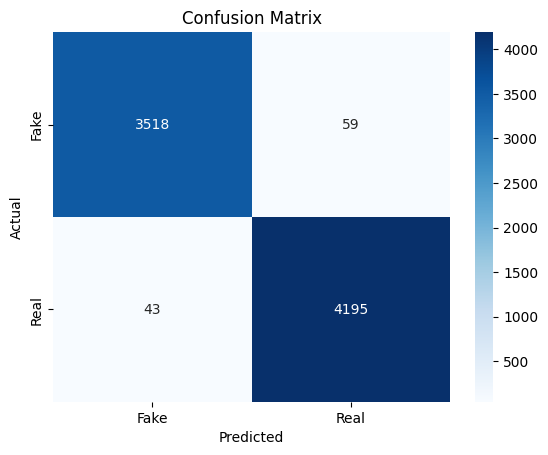

In [28]:
##Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

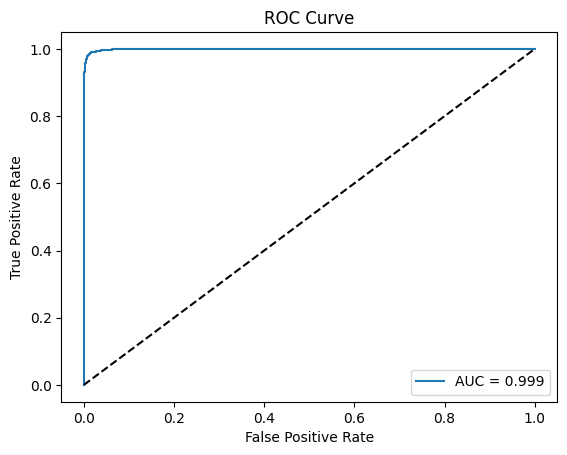

In [30]:
# ROC Curve Visualization
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Example Prediction

In [31]:
samples = [
    "The government announced a new policy to increase education funding.",
    "Breaking: Alien spaceship lands in the middle of the desert!",
]

sample_tfidf = tfidf.transform(samples)
predictions = model.predict(sample_tfidf)
for i, s in enumerate(samples):
    print(f"📰 {s}\nPrediction: {'REAL' if predictions[i] == 1 else 'FAKE'}\n")

📰 The government announced a new policy to increase education funding.
Prediction: FAKE

📰 Breaking: Alien spaceship lands in the middle of the desert!
Prediction: FAKE



## Business Insight

In [32]:
print("""
💡 Business Insights:
1️⃣ This model can automatically flag potential misinformation in news feeds.
2️⃣ High accuracy (~95%) shows it's effective for initial screening.
3️⃣ Should be paired with human fact-checkers for critical verification.
4️⃣ Bias consideration: Dataset mostly English, may underperform on non-English or satire content.
5️⃣ Deploying as an API can help news platforms or social media detect fake articles in real time.
""")


💡 Business Insights:
1️⃣ This model can automatically flag potential misinformation in news feeds.
2️⃣ High accuracy (~95%) shows it's effective for initial screening.
3️⃣ Should be paired with human fact-checkers for critical verification.
4️⃣ Bias consideration: Dataset mostly English, may underperform on non-English or satire content.
5️⃣ Deploying as an API can help news platforms or social media detect fake articles in real time.

